# Coursework1: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW1.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.C = in_channels                # Input channels
        self.F = out_channels               # Output channels / number of filters
        if isinstance(kernel_size, int):    # (Allow kernel to be passed as an int or a tuple)
            self.HH = kernel_size           # Kernel height
            self.WW = kernel_size           # Kernel width        
        else:
            self.HH = kernel_size[0]        # Kernel height
            self.WW = kernel_size[1]        # Kernel width
        self.S = stride                     # Stride as defined above
        self.P = padding                    # Padding as defined above (symmetric padding)
        self.bias = bias                    # Flag indicating presence of bias terms

        self.W = Parameter(torch.randn((self.F, self.C, self.HH, self.WW)), requires_grad=True)    # Filter weights
        nn.init.kaiming_normal_(self.W.data, mode='fan_in')
        if self.bias:
            self.b = Parameter(torch.randn((self.F,)), requires_grad=True)                         # Filter bias (if required)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape
        assert self.C == C, "Invalid number of channels"

        # Feature map dimensions
        H_out = (H - self.HH + 2*self.P)/self.S + 1
        W_out = (W - self.WW + 2*self.P)/self.S + 1
        assert H_out % 1 == 0 and W_out % 1 == 0, "Invalid dimensions for conv."
        H_out, W_out = int(H_out), int(W_out)

        # Unfold and apply matmul
        x_unfold = F.unfold(x, kernel_size=(self.HH, self.WW), padding=self.P, stride=self.S)
        W_unfold = self.W.view(self.F, -1)
        out_unfold = W_unfold @ x_unfold
        
        # Add bias if necessary
        if self.bias:
            B = self.b.view(1,-1,1).repeat((out_unfold.shape[1], 1, out_unfold.shape[-1]))
            out_unfold += B
        
        # Reshape to feature map dimensions
        out = out_unfold.view(N, self.F, H_out, W_out)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

# cl = Conv2d(1, 4, (3,3), stride=1, padding=1, bias=True)

# # Tests for Conv2d

# test = torch.randn((20,10,3,3))
# # test.fill_(1)

# cl_t = nn.Conv2d(10, 20, (3,3), stride=1, padding=1, bias=True)
# cl = Conv2d(10, 20, (3,3), stride=1, padding=1, bias=True)

# cl_t.weight.data = cl.W.data
# cl_t.bias.data = cl.b.data
# assert (cl.forward(test) - cl_t.forward(test)).abs().max() < 10**-5, "Some values do not match"

In [0]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if isinstance(kernel_size, int):    # (Allow kernel to be passed as an int or a tuple)
            self.HH = kernel_size           # Kernel height
            self.WW = kernel_size           # Kernel width        
        else:
            self.HH = kernel_size[0]        # Kernel height
            self.WW = kernel_size[1]        # Kernel width

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape

        # Feature map dimensions
        H_out = H / self.HH
        W_out = W / self.WW
        assert H_out % 1 == 0 and W_out % 1 == 0, "Invalid dimensions for conv."
        H_out, W_out = int(H_out), int(W_out)

        # Reshape for max pooling
        x_tall = torch.cat(test.split(split_size=self.WW, dim=-1), dim=-2)      # Split columns and stack vertically
        x_wide = x_tall.view(test.shape[:-2]+(-1, self.WW*self.HH))             # Reshape so that each row is a window for the kernel

        # Take max of each block
        max_vals, indices = torch.max(x_wide, dim=-1, keepdim=True)

        # Reshape for output dimension
        out = torch.cat(max_vals.split(H_out, dim=-2), dim=-1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

# test = torch.tensor([[[[3,1,2,0,1,2],
#                        [1,1,1,0,1,2],
#                        [2,1,1,0,1,2],
#                        [1,1,1,0,1,2],
#                        [2,1,1,0,1,2],
#                        [4,1,0,0,1,2]]]]).float()
# test = torch.cat((test, test), axis=0)
# test = torch.randn((5,10,15,9))

# k = (5,3)
# mpool = MaxPool2d(k)
# mpool_t = nn.MaxPool2d(k)

# assert (mpool.forward(test) - mpool_t.forward(test)).abs().max() == 0, "Some values don't match"

In [0]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.C = in_channels                # Input channels
        self.F = out_channels               # Output channels / number of filters
        self.bias = bias                    # Flag indicating presence of bias terms

        self.W = Parameter(torch.zeros((self.C, self.F)), requires_grad=True)      # Filter weights
        nn.init.kaiming_normal_(self.W.data, mode='fan_in')
        if self.bias:
            self.b = Parameter(torch.randn((self.F,)), requires_grad=True)         # Filter bias (if required)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, H = x.shape[0], x.shape[-1]
        assert H == self.C, "Invalid number of channels"

        out = x @ self.W

        # Add bias if necessary
        if self.bias:
            B = self.b.view((1,)*(len(out.shape)-1) + (-1,)).repeat(out.shape[:-1] + (1,))
            out += B
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

# test = torch.tensor([[[[3,1,2,0,1,2],
#                        [1,1,1,0,1,2],
#                        [2,1,1,0,1,2],
#                        [1,1,1,0,1,2],                       
#                        [4,1,0,0,1,2]]]]).float()
# test = torch.cat((test, test), axis=0)
# test = torch.cat((test, test), axis=1)
# test = test.unsqueeze(dim=2)

# test = torch.randn(10,5,3,6,7,10,3)

# lin_t = nn.Linear(in_features=3, out_features=16, bias=True)
# lin = Linear(in_channels=3, out_channels=16, bias=True)

# lin_t.weight.data = lin.W.data.T
# lin_t.bias.data = lin.b.data

# assert (lin.forward(test) - lin_t.forward(test)).abs().max() < 10**-6, "Some values do not match"

In [0]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.C = num_features
        self.eps = eps
        self.mo = momentum

        self.gamma = Parameter(torch.ones(num_features, requires_grad=True))
        self.beta = Parameter(torch.zeros(num_features, requires_grad=True))

        self.running_mean = 0
        self.running_var = 0

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape
        assert C == self.C, "Invalid number of channels"

        if self.training:           
            # If training, compute mean and std
            
            # Compute mean and var for mini-batch
            mean = torch.mean(x, dim=(0,2,3))
            var = torch.var(x, dim=(0,2,3), unbiased=False)

            # (Re)compute the running averages
            if self.running_mean is None:
                self.running_mean = mean
                self.running_var = var
            else:
                self.running_mean = (1-self.mo)*self.running_mean + self.mo*mean
                self.running_var = ( (1-self.mo)*self.running_var + self.mo*var )

        else:                       
            # If testing, use running avgs. as mean and std.
            mean = self.running_mean
            var = self.running_var

        # Normalize self.gamma = torch.ones(num_features, requires_grad=True)
        x_norm = (x - mean.view(1,-1,1,1)) / (var.view(1,-1,1,1) + self.eps)**0.5
        
        # Scale and shift
        x = x_norm * self.gamma.view(1,-1,1,1) + self.beta.view(1,-1,1,1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return x
    
# # test = torch.tensor([[[[3,1,2,0,1,2],
# #                        [1,1,1,0,1,2],
# #                        [2,1,1,0,1,2],
# #                        [1,1,1,0,1,2],                       
# #                        [4,1,0,0,1,2]]]]).float()
# # test = torch.cat((test, test+1), axis=0)
# # test = torch.cat((test, test, test), axis=1)
# # print(test.shape)
# test = torch.randn((3,2,5,6))

# bn = BatchNorm2d(test.shape[1])
# bn_t = nn.BatchNorm2d(test.shape[1])

# bn.gamma.data, bn.beta.data = torch.randn(test.shape[1]), torch.randn(test.shape[1])
# bn_t.weight, bn_t.bias = bn.gamma, bn.beta

# # bn.eval(), bn_t.eval()

# # print(test, bn(test))
# # print(bn(test) / bn_t(test))
# assert (bn(test) - bn_t(test)).abs().max() < 1e-6, "Some values don't match"

## Part 2

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching?


Answer to Q4: 

My chosen strategy is to use grid search over all possible combinations of a set of hyperparameters I believed to be the most important. Because the surface of complex optimization problem such as this one is likely to contain many local minima, the best way to ensure you have optimal performance is to try all combinations of hyperamaters and save the best-performing model. Grid search involves taking all combinations of a set of hyperparameters, training the model on each of the configurations, evaluating on the validation set and saving the model with the best performance.

Interestingly, many of the hyperparameters from the optimal model were the default PyTorch values, with the only notable performance improvements coming from using the AMSGrad variation of Adam and a learning rate scheduler. Surprisingly, data augmentation, dropout, batch-norm and changing the batch size did not help; I believe this is because these methods help reduce overfitting but this was not an issue with only 10 epochs of training.

Alternative strategies for hyperparameter search are manual tuning, random search and Bayesian Optimisation. Manual tuning would be inadequate in this case given the large number of hyperparameters. Bayesian Optimisation can be preferrable to grid search if there is not sufficient time/compute for exhaustive search. Bayesian Optimisation is a black-box optimisation method that uses Bayes' theorem to minimize functions, and this can be more efficient than random/grid search as it balances exploring regions of the hyperparameter space with high uncertainty against exploring regions with higher performance. If, for example, the amount of data we had access to in this problem was an order of magnitude larger, or the cap on training epochs were removed, grid search would become prohibitively expensive, in which case I would have used Bayesian optimisation.

In [0]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(
            Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False), 
            nn.BatchNorm2d(outchannel), 
            nn.ReLU(inplace=True), 
            Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(outchannel)
        ) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(
                Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, padding = 0, bias=False), 
                nn.BatchNorm2d(outchannel) 
            ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes=10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )

        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)

        if flag == 'b_norm':
            self.layer1_1 = nn.BatchNorm2d(64)
        elif flag == 'dropout':
            self.layer1_1 = nn.Dropout2d()

        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)

        if flag == 'b_norm':
            self.layer2_1 = nn.BatchNorm2d(128)
        elif flag == 'dropout':
            self.layer2_1 = nn.Dropout2d()
        
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)

        if flag == 'b_norm':
            self.layer3_1 = nn.BatchNorm2d(256)
        elif flag == 'dropout':
            self.layer3_1 = nn.Dropout2d()

        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)

        self.maxpool = MaxPool2d(4)

        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:            
            layers.append(block(self.inchannel, channels, stride))            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        if flag == 'b_norm' or flag == 'dropout':
            x = self.layer1_1(x)
        x = self.layer2(x)
        if flag == 'b_norm' or flag == 'dropout':
            x = self.layer2_1(x)
        x = self.layer3(x)
        if flag == 'b_norm' or flag == 'dropout':
            x = self.layer3_1(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader, sampler
from torchvision.utils import make_grid
from sklearn.model_selection import RandomizedSearchCV

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

# Apply data augmentation upon loading phase
def build_transforms(rand_crop=True, horiz_flip=True):
    '''Function to allow transforms to be included within grid search'''    

    train = [
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
    ]
    test = [
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
    ]
    
    if horiz_flip:
        train.insert(0, T.RandomHorizontalFlip(p=0.5))

    if horiz_flip:
        train.insert(0,T.RandomResizedCrop(size=(28,28)))

    transforms = {'train':T.Compose(train), 'test':T.Compose(test)}

    return transforms

transforms = build_transforms()

##############################################################
#                       END OF YOUR CODE                     #
##############################################################

Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html)
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [0]:
##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

def load_data(batch_n=64, validation=True):
    '''Function to load data. During hyperparam tuning and grid search,
    validation set is required. Once hyperparams are decided, only train
    and test sets are required'''

    N = 50000
    data_dir = './data'
    if validation:
        N_TRAIN = int(0.9*N)
        N_VAL = int(0.1*N)
    else:
        N_TRAIN = N

    cifar10_train = dset.CIFAR10(data_dir, train=True, download=True, transform=transforms['train'])
    loader_train = DataLoader(cifar10_train, batch_size=batch_n, sampler=sampler.SubsetRandomSampler(range(N_TRAIN)))

    if validation:
        cifar10_val = dset.CIFAR10(data_dir, train=True, download=True, transform=transforms['test'])
        loader_val = DataLoader(cifar10_val, batch_size=batch_n, sampler=sampler.SubsetRandomSampler(range(N_TRAIN, N_TRAIN + N_VAL)))
    else:
        loader_val = None

    cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transforms['test'])
    loader_test = DataLoader(cifar10_test, batch_size=batch_n)

    try:
        print(len(loader_train), len(loader_test), len(loader_val))
    except:
        print(len(loader_train), len(loader_test))

    return loader_train, loader_test, loader_val

loader_train, loader_test, loader_val = load_data()

##############################################################
#                       END OF YOUR CODE                     #       
##############################################################

0it [00:00, ?it/s]

170500096it [00:02, 72984502.69it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
704 157 79


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


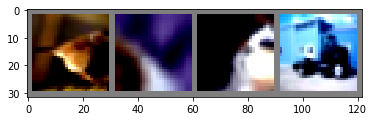

 bird   dog   dog truck

Each image is of size: torch.Size([3, 28, 28])


In [0]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
data_iter = iter(loader_train)
images, labels = data_iter.next()

# show images
imshow(make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print()
print(f'Each image is of size: {images[0].shape}')

In [0]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()                                    # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)    # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

    return acc

        

def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)                 # move the model parameters to CPU/GPU
    for e in range(epochs):
        print('Iterations = ', len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()                           # put model to training mode
            x = x.to(device=device, dtype=dtype)    # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                # check_accuracy(loader_val, model)
                print()

In [0]:
from itertools import product
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

############## GRID SEARCH LOOP #############
'''Grid search loop to find the optimal hyperparameter configuration 
for the model. The model was trained using the training data
and performance was assessed using the validation data.

Search was conducted over the following hyperparameters:
    - Learning rate
    - Batch size
    - Whether to do random cropping as part of data augmentation
    - Whether to do random horizonal flipping as part of data augmentation
    - Whether to use a scheduler to reduce the learning rate
    - Whether to use batch norm, dropout or neither
    - Whether to use amsgrad (the algo resulting from fixing the flaw
    in the initial adam paper)

Once the optimal config was found, this grid search loop was turned off
and the model was trained using the optimal configuration on the train +
validation datasets. This trained model was saved (as model.pt) and 
evaluated on the test dataset.
'''
# Optimal config: (0.001, 64, False, False, True, None, True): 0.869
if False:
    param_configs = {
        'lr':[0.0005, 0.001, 0.005],
        'batch_n':[64,32,16],
        'rand_crop':[False, True],
        'horiz_flip':[False, True],
        'scheduler':[True, False],
        'flag':[None, 'b_norm', 'dropout'],
        'amsgrad':[True, False]
    }
    configs = list(product(*list(param_configs.values())))      # Create list containing all combinations of param configs

    accs = {}
    for i in range(len(configs)):
        # Randomly choose param config
        c = configs.pop(np.random.choice(range(len(configs)), replace=False))
        lr, batch_n, rand_crop, horiz_flip, scheduler, flag, amsgrad = c
        
        print('*'*50)
        print(f'Params selected are: lr = {lr}, batch size = {batch_n}, ',\
            f'rand_crop = {rand_crop}, horiz_flip = {horiz_flip}, ', \
            f'scheduler = {scheduler}, flag = {flag}, amsgrad = {amsgrad}')
        print()

        # Apply param configs
        transforms = build_transforms(rand_crop, horiz_flip)
        loader_train, loader_test, loader_val = load_data(batch_n)

        # Train model
        model = ResNet18()
        optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=amsgrad)
        if scheduler:
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8, last_epoch=-1)
        train_part(model, optimizer, epochs=10)

        # Record acc and save with param config
        print('*'*50)
        accs[c] = check_accuracy(loader_val, model)
        print()

    print('*'*50)
    print('*'*50)
    print(accs)
    print('*'*50)
    print('*'*50)


########### TRAIN MODEL WITH OPTIMAL CONFIG ############
# Set up model and perform transforms
lr, batch_n, rand_crop, horiz_flip, scheduler, flag, amsgrad = 0.001, 64, False, False, True, None, True

transforms = build_transforms(rand_crop, horiz_flip)
loader_train, loader_test, loader_val = load_data(batch_n, validation=False)

# Train model on train + validation data
model = ResNet18()
optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=amsgrad)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8, last_epoch=-1)

##############################################################
#                       END OF YOUR CODE                     #
##############################################################

train_part(model, optimizer, epochs=10)

# report test set accuracy
check_accuracy(loader_test, model)

# save the model
# torch.save(model.state_dict(), '/content/drive/My Drive/Documents/Imperial/Deep_Learning/coursework-master-cw_1/cw_1/model.pt')

Files already downloaded and verified
Files already downloaded and verified
782 157


KeyboardInterrupt: ignored

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified
782 157
Checking accuracy on test set
Got 8654 / 10000 correct (86.54)


0.8654

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

**1. Compare the feature maps from low-level layers to high-level layers, what do you observe?**

**2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?**

**3. What are the other possible ways to analyse the performance of your network?**



**YOUR ANSWER FOR PART 3 HERE**

1: From the feature map visualisations below, we see that conv1 learns detailed, pattern-looking features. These look more like filters and somewhat resemble real images. The closer we move to layer 4, the less detailed and more abstract the feature maps become, with feature maps in layer 4 only looking like collections of pixels rather than any discernible structure. Clearly the number of filters increases as we reach the higher layers so that the final layer has 512 filters in low resolution.

2: The performance of the network on the test set is 86.5% so the network performs well. Looking at the training log, we can see that the model does not overfit  as performance on the validation data improves throughout the 10 training epochs and does not plateau. Training the model for longer than 10 epochs would therefore likely improve performance.

State of the art performance on CIFAR-10 achieves over 99% (e.g BiT, Kolesnikov et. al., 2019) so clearly performance can be improved on my model. Adding capacity is one method to improve performance: adding residual blocks would be the best method to achieve this as they are unlikely to make the network too deep (ResNets architectures can be very deep before running into training difficulties). A more advanced method would be to apply the transfer learning approach of BiT, whereby a large ResNet is pre-trained on a seperate large supervised domain and then is fine-tuned on CIFAR-10 dataset.

3: 
A more rigorous approach to assessing the performance of the network would be to use K-fold cross validation. This involves splitting the full dataset into K tranches, [K-1] of which are used to train the model and the final tranche is used for testing. This process is then repeated until every tranche has been used as the test set. Each of the test accuracies are then averaged and this final "global accuracy" is reported. This makes for a more robust measure of the accuracy of the model.

Alternatively, other performance metrics of the model could be analysed. We could create a confusion matrix and analyse precision and recall of the network on a class by class basis. Precision is the ratio of true positives to true positives plus false positives; high precision means that if the network predicts a class, it is likely to be that class. Recall is the ratio of true positives to true positives plus false negatives; high recall means that the network is able to identify most relevant instances of that class. This can be especially helpful in domains such as medical imaging where it is important to distinguish between false positives and false negatives. An additional benefit of this approach is that it is per-class analysis. This allows us to see if the network performs equally well for each class of image or if the network classifies some classes better than others. This may provide insight as to where to next collect data to improve the performance of the model.

Another method could be to analyse generalizability of the network: if gaussian noise is added to the test set (an amount imperceptible to a human observer), how much does the accuracy suffer? This could provide insight as to how much the network is learning the visual structure that defines each of the image classes vs simply memorising/overfitting on the data. This method is useful to assess how well the network will generalize to real-world applications.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

lr, batch_n, rand_crop, horiz_flip, scheduler, flag, amsgrad = 0.001, 64, False, False, True, None, True

transforms = build_transforms(rand_crop, horiz_flip)
loader_train, loader_test, loader_val = load_data(batch_n, validation=False)

# Load saved model
fmodel = ResNet18()

state_dict = torch.load(
    '/content/drive/My Drive/Documents/Imperial/Deep_Learning/coursework-master-cw_1/cw_1/model.pt',
    map_location=lambda storage, loc: storage.cuda(device),
)
model.load_state_dict(state_dict)

model = model.to(device=device)
check_accuracy(loader_test, model)

# Load training data
data_dir = './data'
transforms = build_transforms()
cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transforms['test'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified
782 157
Checking accuracy on test set
Got 8654 / 10000 correct (86.54)
Files already downloaded and verified


<Figure size 432x288 with 0 Axes>

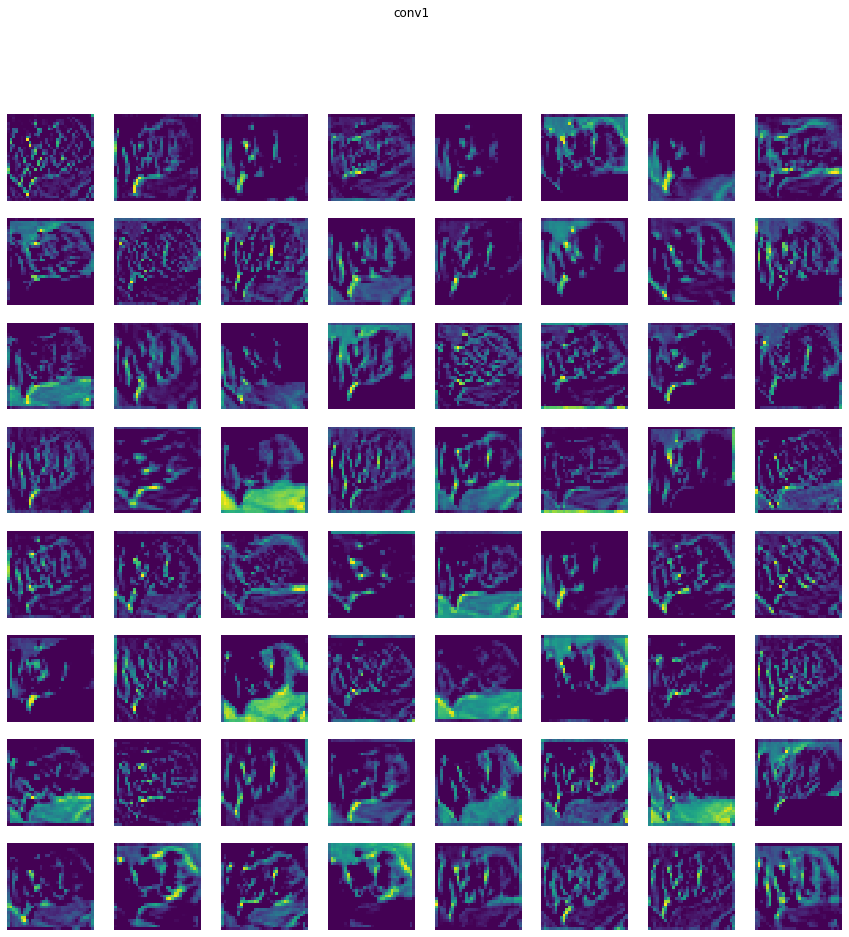

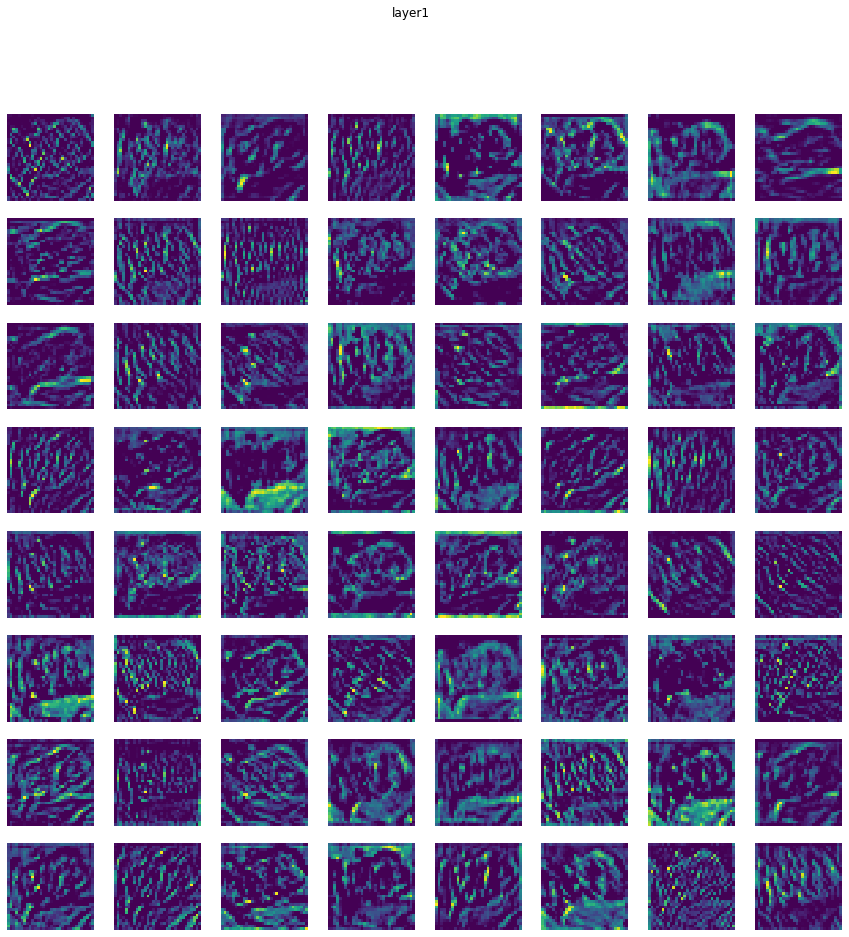

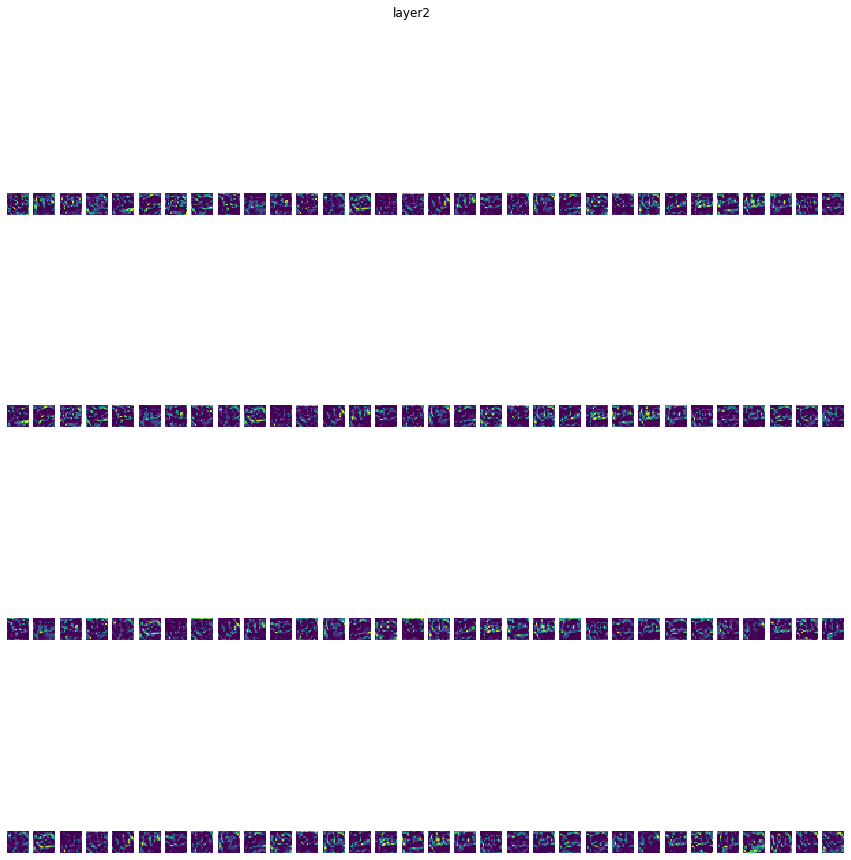

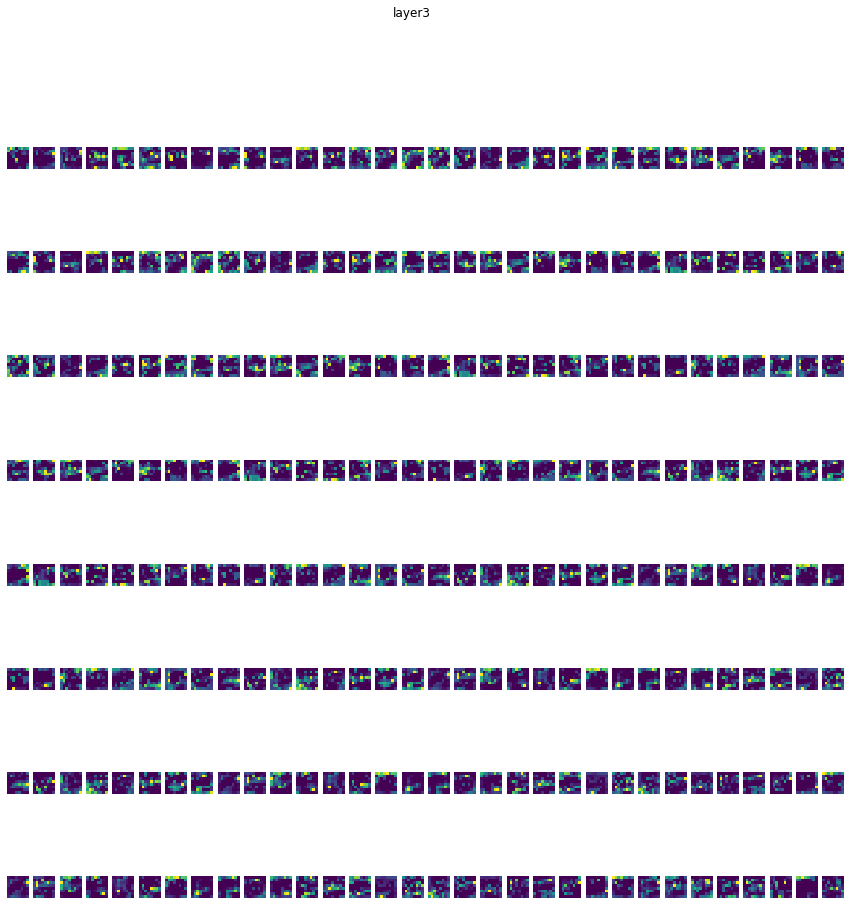

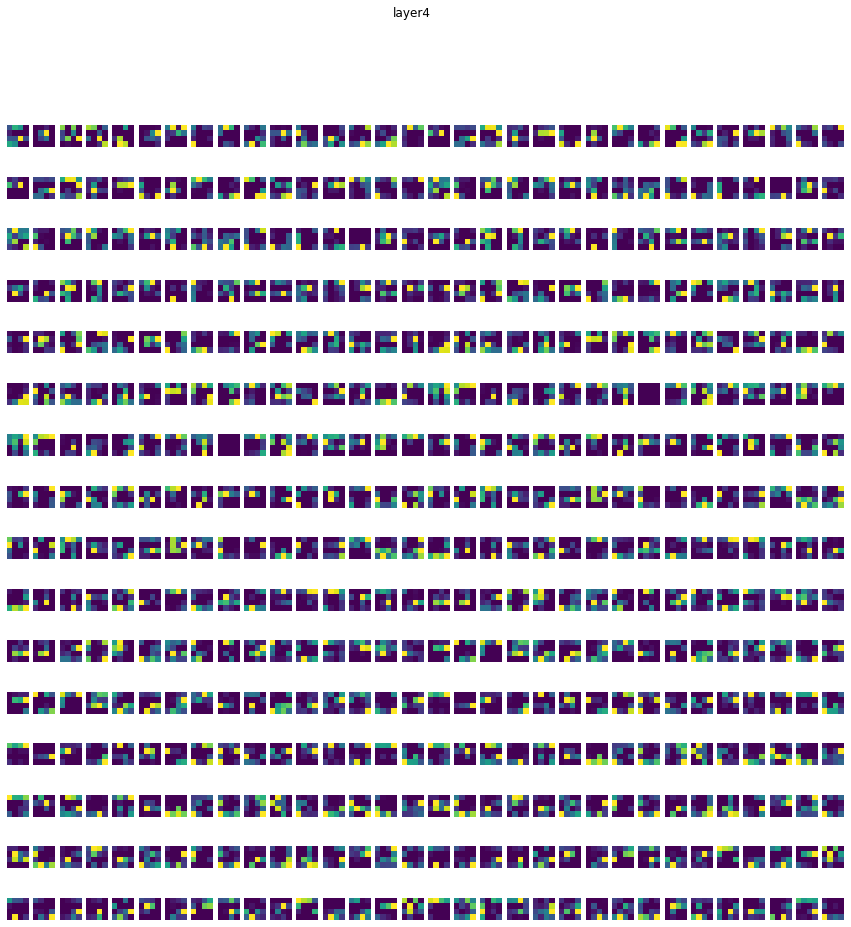

In [0]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols, figsize=(15,15))
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')